Library Imports & Environment Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
import shap
import joblib

Dataset Loading & Initial Cleaning

In [2]:
df = pd.read_csv("Car_price_dataset.csv")

for col in df.columns:
    if col.lower().startswith("unnamed"):
        df = df.drop(columns=[col])

df.columns = [c.strip() for c in df.columns]

print("Shape:", df.shape)
df.head()

Shape: (9788, 16)


,Brand,Model,YOM,Engine (cc),Gear,Fuel Type,Millage(KM),Town,Date,Leasing,Condition,AIR CONDITION,POWER STEERING,POWER MIRROR,POWER WINDOW,Price
0,AUDI,A1,2016,990.0,Automatic,Petrol,99000.0,Gampaha,2025-02-05,No Leasing,USED,Available,Available,Available,Available,100.0
1,AUDI,A1,2017,1000.0,Automatic,Petrol,88000.0,Colombo,2025-01-14,No Leasing,USED,Available,Available,Available,Available,97.0
2,AUDI,A1,2018,1000.0,Automatic,Petrol,77000.0,Dehiwala-Mount-Lavinia,2025-01-23,No Leasing,USED,Available,Available,Available,Available,98.5
3,AUDI,A1,2017,1000.0,Automatic,Petrol,88000.0,Negombo,2024-12-21,No Leasing,USED,Available,Available,Available,Available,107.0
4,AUDI,A1,2017,1000.0,Automatic,Petrol,88000.0,Colombo,2024-12-21,No Leasing,USED,Available,Available,Available,Available,99.5


Dataset Overview & Structure

In [3]:
df.info()
df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9788 entries, 0 to 9787
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           9788 non-null   object 
 1   Model           9788 non-null   object 
 2   YOM             9788 non-null   int64  
 3   Engine (cc)     9788 non-null   float64
 4   Gear            9788 non-null   object 
 5   Fuel Type       9788 non-null   object 
 6   Millage(KM)     9788 non-null   float64
 7   Town            9788 non-null   object 
 8   Date            9788 non-null   object 
 9   Leasing         9788 non-null   object 
 10  Condition       9788 non-null   object 
 11  AIR CONDITION   9788 non-null   object 
 12  POWER STEERING  9788 non-null   object 
 13  POWER MIRROR    9788 non-null   object 
 14  POWER WINDOW    9788 non-null   object 
 15  Price           9788 non-null   float64
dtypes: float64(3), int64(1), object(12)
memory usage: 1.2+ MB


,Brand,Model,YOM,Engine (cc),Gear,Fuel Type,Millage(KM),Town,Date,Leasing,Condition,AIR CONDITION,POWER STEERING,POWER MIRROR,POWER WINDOW,Price
count,9788,9788,9788.000000,9788.000000,9788,9788,9788.000000,9788,9788,9788,9788,9788,9788,9788,9788,9788.000000
unique,50,1555,NaN,NaN,2,4,NaN,107,65,2,2,2,2,2,2,NaN
top,TOYOTA,ALTO,NaN,NaN,Automatic,Petrol,NaN,Colombo,2025-02-05,No Leasing,USED,Available,Available,Available,Available,NaN
freq,3089,392,NaN,NaN,6305,7866,NaN,1038,645,9384,9694,9590,8918,7281,8003,NaN
mean,NaN,NaN,2006.759093,1260.442358,NaN,NaN,200649.979567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.464275
std,NaN,NaN,9.831574,403.769059,NaN,NaN,108147.314860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.625049
min,NaN,NaN,1956.000000,573.000000,NaN,NaN,11000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.650000
25%,NaN,NaN,2001.000000,1000.000000,NaN,NaN,110000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.250000
50%,NaN,NaN,2009.000000,1300.000000,NaN,NaN,176000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.000000
75%,NaN,NaN,2015.000000,1500.000000,NaN,NaN,264000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.750000


Missing Value Analysis

In [4]:
df.isnull().sum().sort_values(ascending=False)

Brand             0
Model             0
YOM               0
Engine (cc)       0
Gear              0
Fuel Type         0
Millage(KM)       0
Town              0
Date              0
Leasing           0
Condition         0
AIR CONDITION     0
POWER STEERING    0
POWER MIRROR      0
POWER WINDOW      0
Price             0
dtype: int64

Outlier Detection & Removal (IQR Method)

In [5]:
# Remove extreme outliers using IQR
Q1 = df["Price"].quantile(0.25)
Q3 = df["Price"].quantile(0.75)
IQR = Q3 - Q1

df = df[(df["Price"] >= Q1 - 1.5*IQR) & 
        (df["Price"] <= Q3 + 1.5*IQR)]

Target Variable Distribution (Vehicle Price)

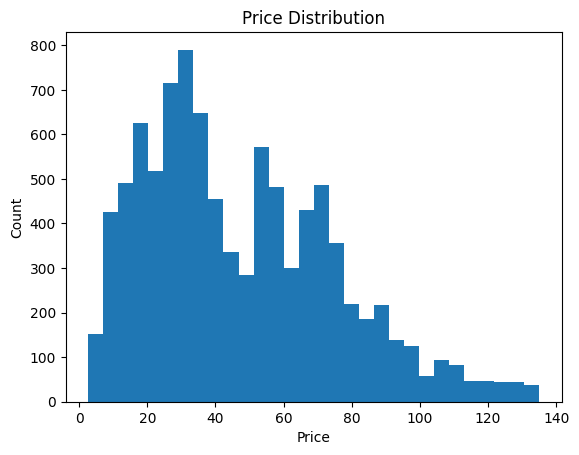

Min: 2.65
Max: 135.0
Mean: 47.37200529307664


In [6]:
plt.figure()
plt.hist(df["Price"], bins=30)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

print("Min:", df["Price"].min())
print("Max:", df["Price"].max())
print("Mean:", df["Price"].mean())

Numerical Feature Exploration

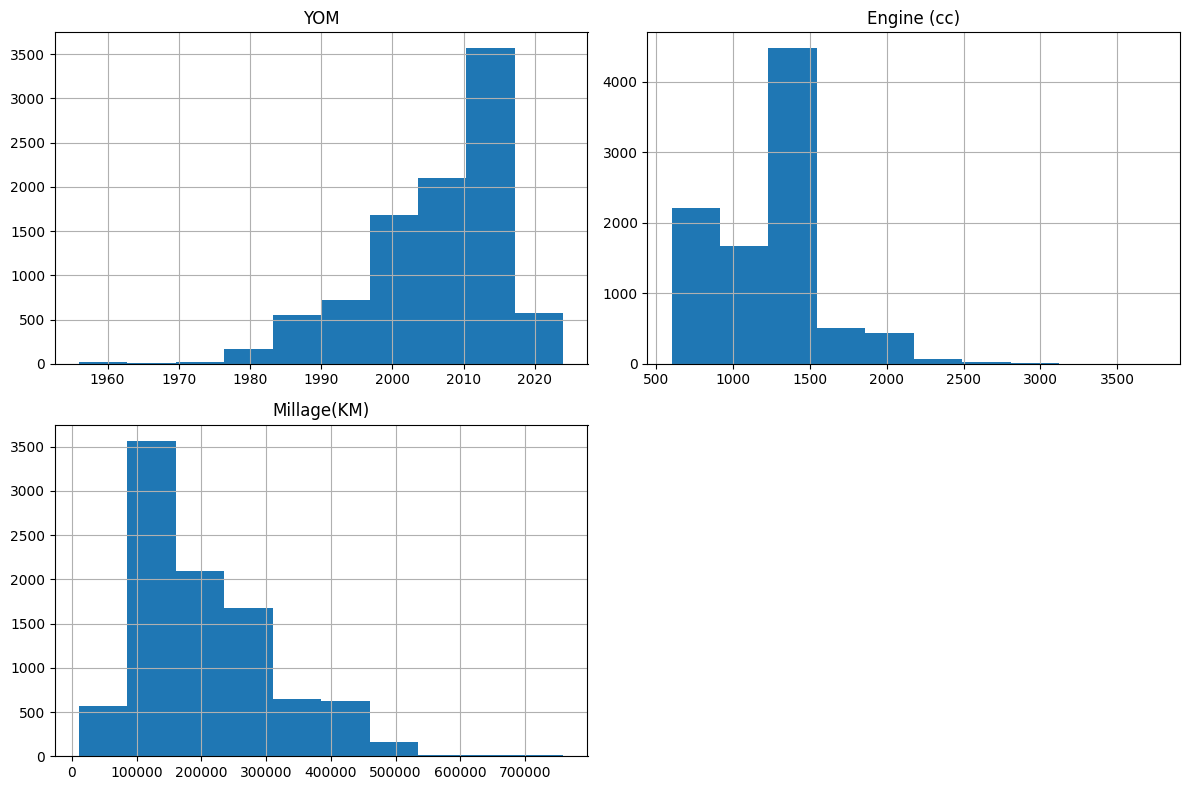

In [7]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols.remove("Price")

df[num_cols].hist(figsize=(12,8))
plt.tight_layout()
plt.show()

Correlation Analysis

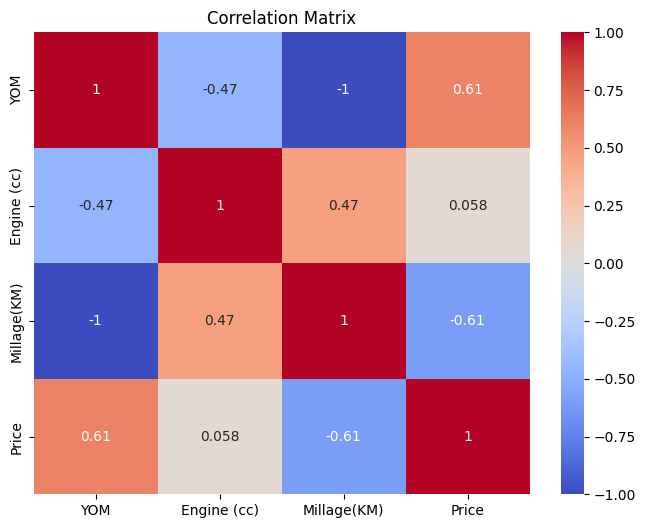

In [8]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Categorical Feature Overview

In [9]:
print(df["Brand"].value_counts().head(10))

Brand
TOYOTA        2928
SUZUKI        2473
NISSAN        1246
HONDA          653
MITSUBISHI     283
PERODUA        257
MICRO          244
HYUNDAI        189
MAZDA          179
TATA           115
Name: count, dtype: int64


Location & Brand Frequency Analysis

In [10]:
print("Shape (rows, cols):", df.shape)
display(df.head(10))
display(df.tail(5))
df.info()

Shape (rows, cols): (9405, 16)


,Brand,Model,YOM,Engine (cc),Gear,Fuel Type,Millage(KM),Town,Date,Leasing,Condition,AIR CONDITION,POWER STEERING,POWER MIRROR,POWER WINDOW,Price
0,AUDI,A1,2016,990.0,Automatic,Petrol,99000.0,Gampaha,2025-02-05,No Leasing,USED,Available,Available,Available,Available,100.000
1,AUDI,A1,2017,1000.0,Automatic,Petrol,88000.0,Colombo,2025-01-14,No Leasing,USED,Available,Available,Available,Available,97.000
2,AUDI,A1,2018,1000.0,Automatic,Petrol,77000.0,Dehiwala-Mount-Lavinia,2025-01-23,No Leasing,USED,Available,Available,Available,Available,98.500
3,AUDI,A1,2017,1000.0,Automatic,Petrol,88000.0,Negombo,2024-12-21,No Leasing,USED,Available,Available,Available,Available,107.000
4,AUDI,A1,2017,1000.0,Automatic,Petrol,88000.0,Colombo,2024-12-21,No Leasing,USED,Available,Available,Available,Available,99.500
5,AUDI,A1,2018,1500.0,Automatic,Petrol,77000.0,Colombo,2024-12-16,No Leasing,USED,Available,Available,Available,Available,91.375
6,AUDI,A1,2017,1000.0,Automatic,Petrol,88000.0,Matara,2024-12-11,No Leasing,USED,Available,Available,Available,Available,104.000
7,AUDI,A1 RS,2016,1000.0,Automatic,Petrol,99000.0,Colombo,2025-01-19,No Leasing,USED,Available,Available,Available,Available,105.000
15,AUDI,A3 SPORTBACK,2017,1000.0,Automatic,Petrol,88000.0,Battaramulla,2025-02-01,No Leasing,USED,Available,Available,Not_Available,Available,125.000
21,AUDI,A4,2001,1900.0,Manual,Diesel,264000.0,Piliyandala,2025-02-04,No Leasing,USED,Available,Available,Available,Available,38.800


,Brand,Model,YOM,Engine (cc),Gear,Fuel Type,Millage(KM),Town,Date,Leasing,Condition,AIR CONDITION,POWER STEERING,POWER MIRROR,POWER WINDOW,Price
9783,ZOTYE,Z100,2018,1000.0,Manual,Petrol,77000.0,Dambulla,2024-12-16,No Leasing,USED,Available,Available,Available,Available,27.50
9784,ZOTYE,Z100,2019,998.0,Manual,Petrol,66000.0,Nittambuwa,2024-12-12,No Leasing,USED,Available,Available,Available,Available,29.00
9785,ZOTYE,Z100,2017,1000.0,Manual,Petrol,88000.0,Anuradapura,2024-12-04,No Leasing,USED,Available,Available,Available,Available,27.50
9786,ZOTYE,ZOTYE,2017,1300.0,Manual,Petrol,88000.0,Gampaha,2025-01-13,No Leasing,USED,Available,Available,Not_Available,Available,8.75
9787,ZOTYE,ZOTYE,1999,1900.0,Automatic,Petrol,286000.0,Kurunegala,2025-01-19,No Leasing,USED,Available,Available,Available,Available,15.50


<class 'pandas.core.frame.DataFrame'>
Index: 9405 entries, 0 to 9787
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           9405 non-null   object 
 1   Model           9405 non-null   object 
 2   YOM             9405 non-null   int64  
 3   Engine (cc)     9405 non-null   float64
 4   Gear            9405 non-null   object 
 5   Fuel Type       9405 non-null   object 
 6   Millage(KM)     9405 non-null   float64
 7   Town            9405 non-null   object 
 8   Date            9405 non-null   object 
 9   Leasing         9405 non-null   object 
 10  Condition       9405 non-null   object 
 11  AIR CONDITION   9405 non-null   object 
 12  POWER STEERING  9405 non-null   object 
 13  POWER MIRROR    9405 non-null   object 
 14  POWER WINDOW    9405 non-null   object 
 15  Price           9405 non-null   float64
dtypes: float64(3), int64(1), object(12)
memory usage: 1.2+ MB


Price Comparison by Vehicle Attributes

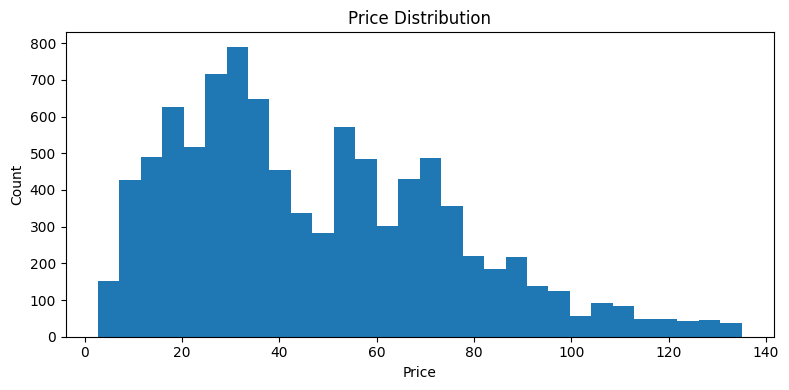

count    9405.000000
mean       47.372005
std        27.922618
min         2.650000
25%        25.750000
50%        40.759091
75%        66.500000
max       135.000000
Name: Price, dtype: float64


In [11]:
plt.figure(figsize=(8,4))
plt.hist(df["Price"], bins=30)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print(df["Price"].describe())

Price vs Year of Manufacture

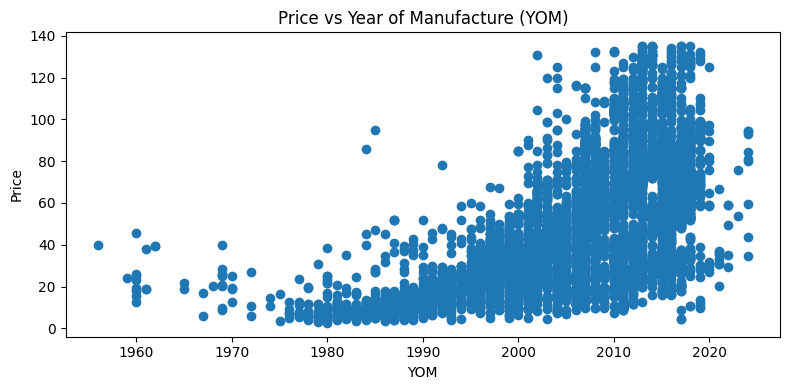

In [12]:
plt.figure(figsize=(8,4))
plt.scatter(df["YOM"], df["Price"])
plt.title("Price vs Year of Manufacture (YOM)")
plt.xlabel("YOM")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

Price vs Mileage

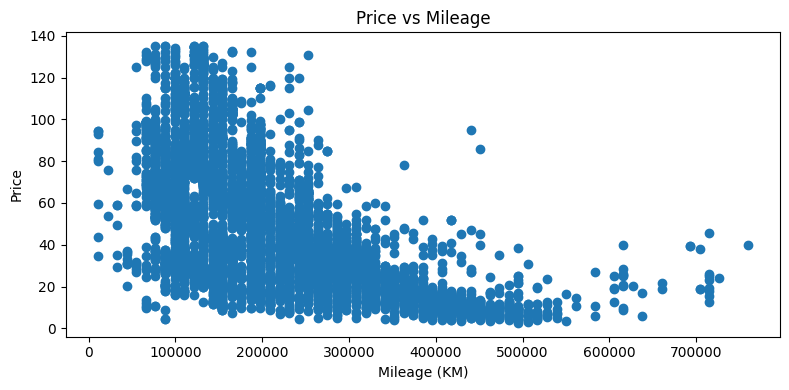

In [13]:
plt.figure(figsize=(8,4))
plt.scatter(df["Millage(KM)"], df["Price"])
plt.title("Price vs Mileage")
plt.xlabel("Mileage (KM)")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

Numeric Feature Distributions

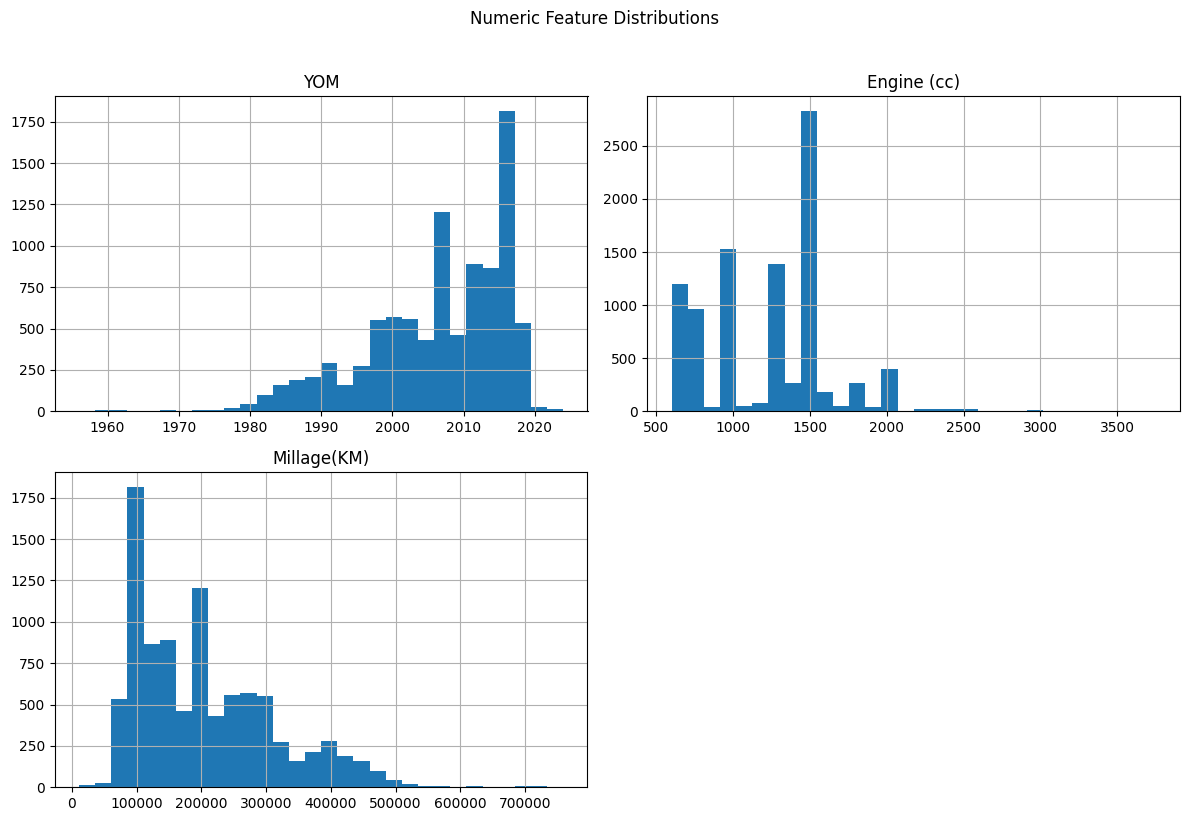

In [14]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols_no_target = [c for c in numeric_cols if c != "Price"]

df[numeric_cols_no_target].hist(figsize=(12,8), bins=30)
plt.suptitle("Numeric Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()

Correlation Heatmap

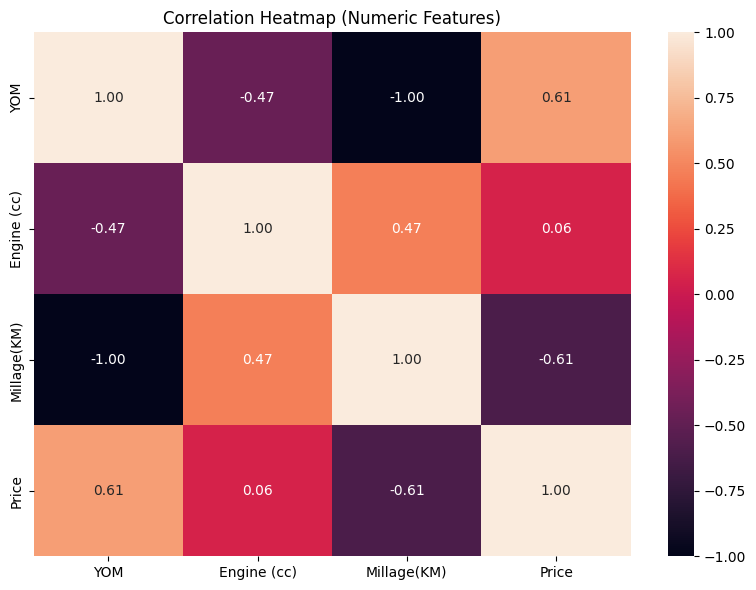

In [15]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()

Categorical Feature Counts

Brand count (Top 15)

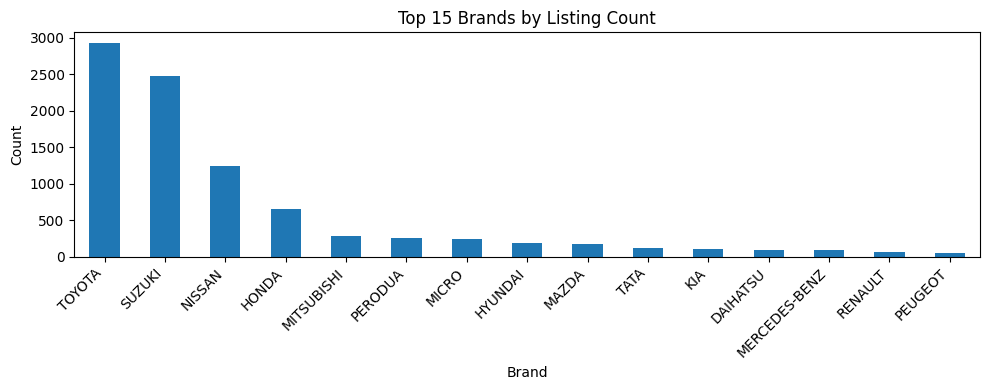

In [16]:
plt.figure(figsize=(10,4))
df["Brand"].value_counts().head(15).plot(kind="bar")
plt.title("Top 15 Brands by Listing Count")
plt.xlabel("Brand")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Town count (Top 15)

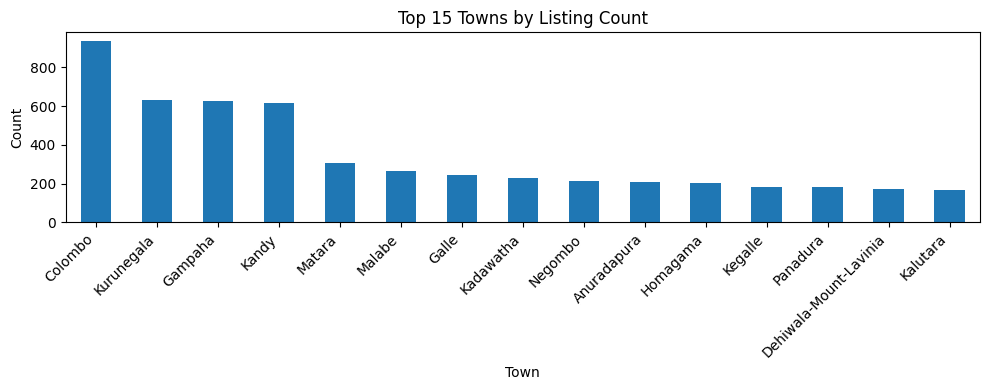

In [17]:
plt.figure(figsize=(10,4))
df["Town"].value_counts().head(15).plot(kind="bar")
plt.title("Top 15 Towns by Listing Count")
plt.xlabel("Town")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Price by Category

Price by Gear Type

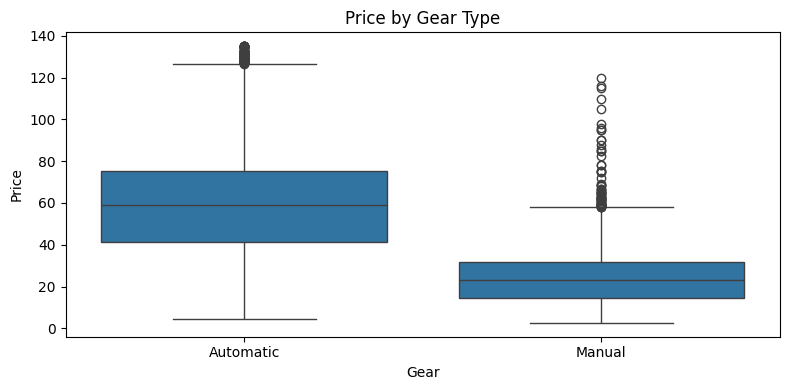

In [18]:
plt.figure(figsize=(8,4))
sns.boxplot(x="Gear", y="Price", data=df)
plt.title("Price by Gear Type")
plt.tight_layout()
plt.show()

Price by Fuel Type

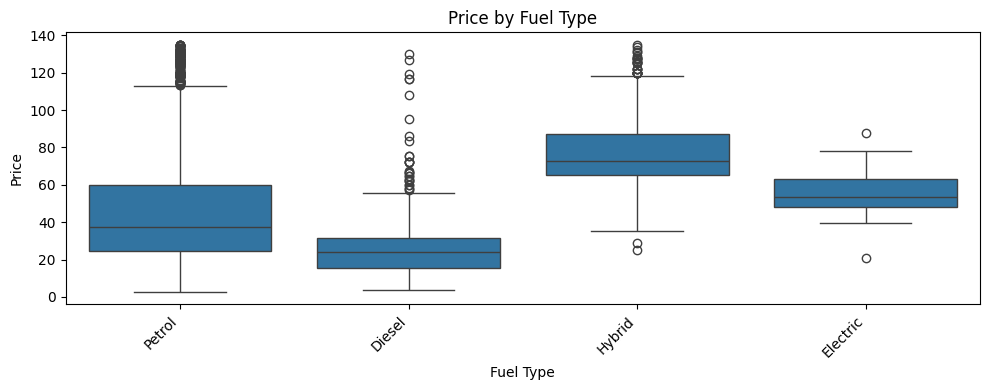

In [19]:
plt.figure(figsize=(10,4))
sns.boxplot(x="Fuel Type", y="Price", data=df)
plt.title("Price by Fuel Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Feature Availability

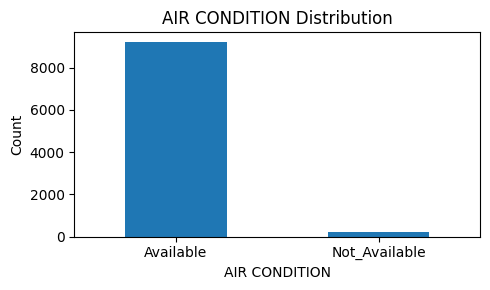

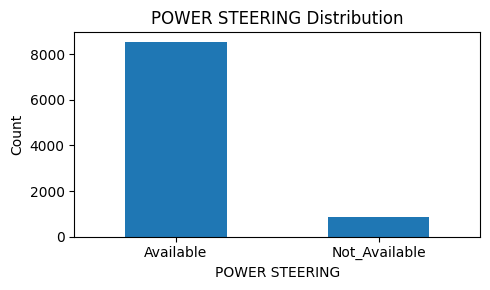

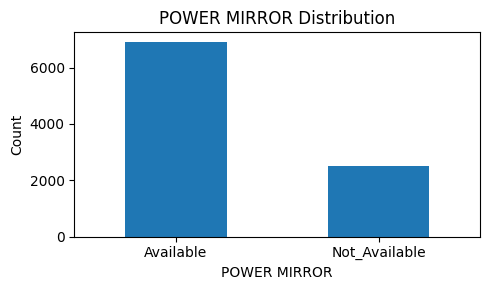

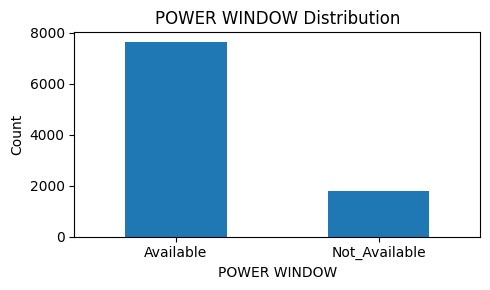

In [20]:
binary_like = ["AIR CONDITION", "POWER STEERING", "POWER MIRROR", "POWER WINDOW"]

for col in binary_like:
    if col in df.columns:
        plt.figure(figsize=(5,3))
        df[col].value_counts().plot(kind="bar")
        plt.title(f"{col} Distribution")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

Data Cleaning

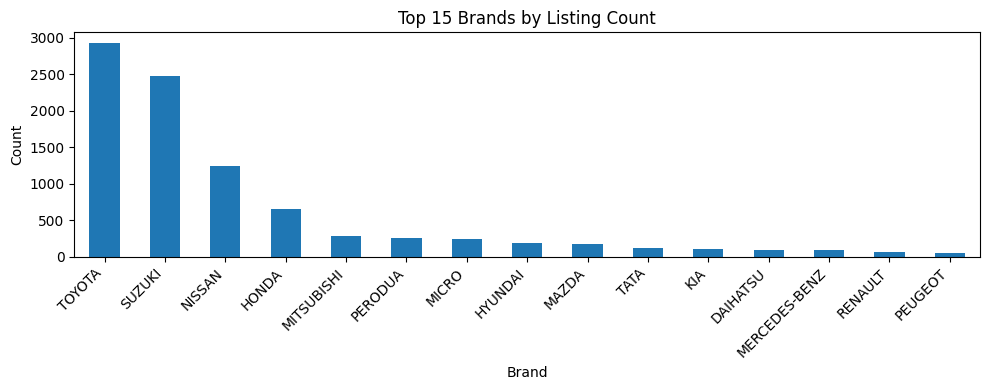

In [21]:
plt.figure(figsize=(10,4))
df["Brand"].value_counts().head(15).plot(kind="bar")
plt.title("Top 15 Brands by Listing Count")
plt.xlabel("Brand")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Top 10 Brand Share

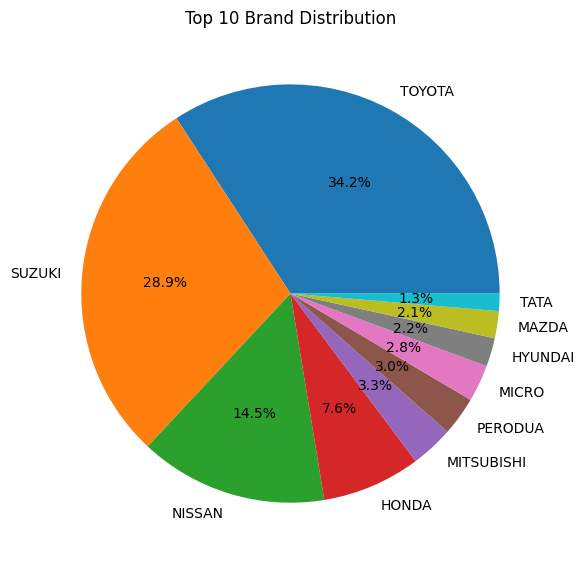

In [22]:
top_brands = df["Brand"].value_counts().head(10)

plt.figure(figsize=(6,6))
plt.pie(top_brands, labels=top_brands.index, autopct="%1.1f%%")
plt.title("Top 10 Brand Distribution")
plt.tight_layout()
plt.show()

Fuel Type Distribution

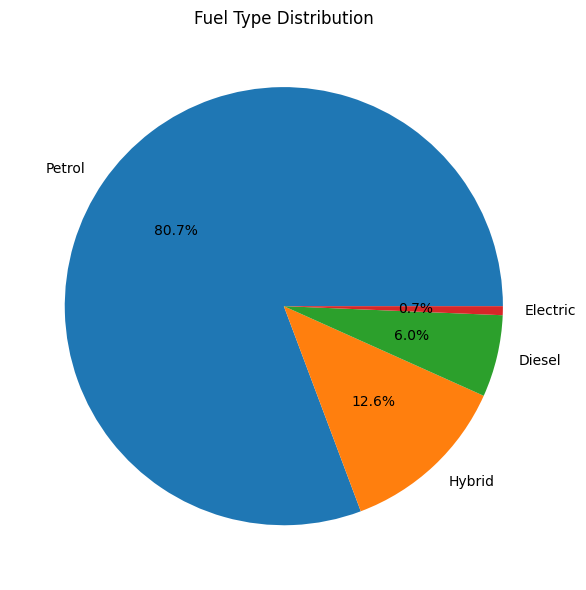

In [23]:
fuel_counts = df["Fuel Type"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(fuel_counts, labels=fuel_counts.index, autopct="%1.1f%%")
plt.title("Fuel Type Distribution")
plt.tight_layout()
plt.show()

Gear Type Distribution

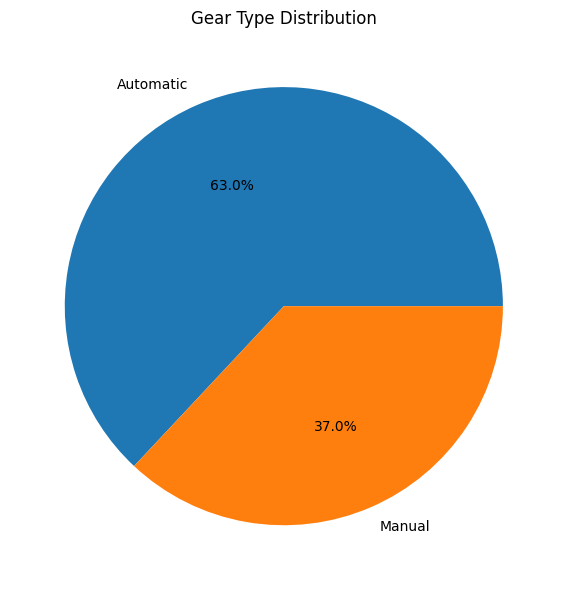

In [24]:
gear_counts = df["Gear"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(gear_counts, labels=gear_counts.index, autopct="%1.1f%%")
plt.title("Gear Type Distribution")
plt.tight_layout()
plt.show()

Leasing Availability

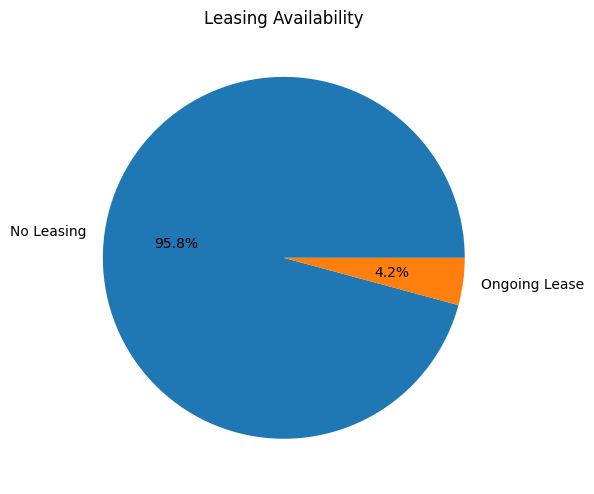

In [25]:
leasing_counts = df["Leasing"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(leasing_counts, labels=leasing_counts.index, autopct="%1.1f%%")
plt.title("Leasing Availability")
plt.tight_layout()
plt.show()

Vehicle Condition

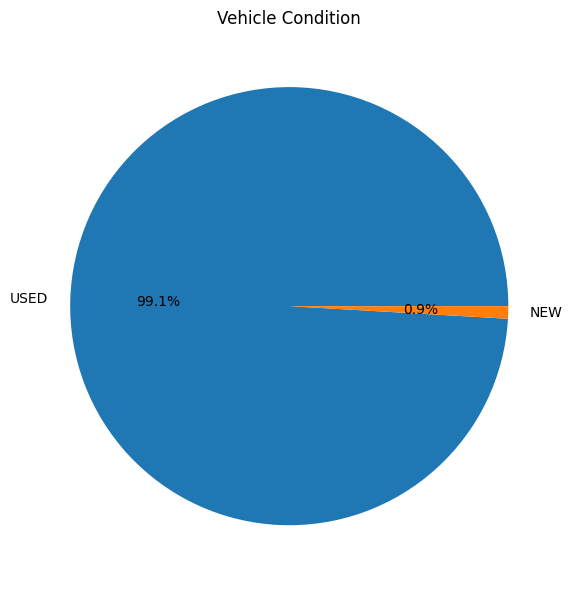

In [26]:
cond_counts = df["Condition"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(cond_counts, labels=cond_counts.index, autopct="%1.1f%%")
plt.title("Vehicle Condition")
plt.tight_layout()
plt.show()

AC Availability

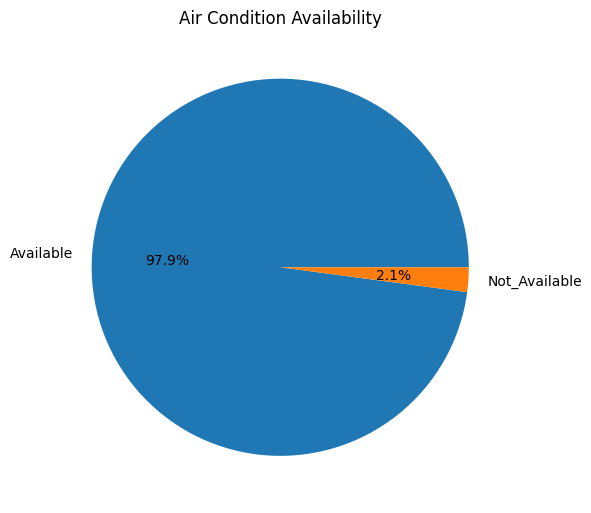

In [27]:
ac_counts = df["AIR CONDITION"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(ac_counts, labels=ac_counts.index, autopct="%1.1f%%")
plt.title("Air Condition Availability")
plt.tight_layout()
plt.show()

Remove duplicates & impossible rows

In [28]:
df = df.drop_duplicates()

df = df.dropna(subset=["Price"])

Feature Engineering

Date Processing & Vehicle Age

In [29]:
# vehicle age
current_year = 2025
df["VehicleAge"] = current_year - df["YOM"]

Features & Target Definition

In [30]:
target = "Price"

X = df.drop(columns=[target])
y = df[target].astype(float)

print("X shape:", X.shape)

X shape: (9388, 16)


In [31]:
# parse Date and create time features
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df["ListingYear"] = df["Date"].dt.year
    df["ListingMonth"] = df["Date"].dt.month
    df = df.drop(columns=["Date"])

for c in ["YOM", "Engine (cc)", "Millage(KM)", "VehicleAge", target]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")


In [32]:
df = df.dropna(subset=[target])

Train / Validation / Test Split

In [33]:
X = df.drop(columns=[target])
y = df[target].astype(float)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print("Shapes:")
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Shapes:
Train: (6571, 17) Val: (1408, 17) Test: (1409, 17)


Preprocessing Pipelines

In [34]:
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)


Evaluation Function

In [35]:
def eval_reg(model, X_eval, y_eval, name="Model"):
    pred = model.predict(X_eval)
    rmse = np.sqrt(mean_squared_error(y_eval, pred))
    mae  = mean_absolute_error(y_eval, pred)
    r2   = r2_score(y_eval, pred)
    print(f"\n{name}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")
    return {"rmse": rmse, "mae": mae, "r2": r2}


Data Preprocessing for XGBoost

In [36]:
X_train_t = preprocess.fit_transform(X_train)
X_val_t = preprocess.transform(X_val)
X_test_t = preprocess.transform(X_test)

Train Baseline XGBoost Model

In [37]:
baseline_xgb = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_estimators=300,       
        learning_rate=0.1,
        max_depth=6,
        subsample=1.0,
        colsample_bytree=1.0,
        n_jobs=-1
    ))
])
baseline_xgb.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['YOM', 'Engine (cc)',
                                                   'Millage(KM)', 'VehicleAge',
                                                   'ListingYear',
                                                   'ListingMonth']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknow...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

Baseline Model Performance on Validation Set

In [38]:
# baseline performance on VAL
baseline_val = eval_reg(baseline_xgb, X_val, y_val, "Baseline XGBoost - VAL")



Baseline XGBoost - VAL
RMSE: 7.3404
MAE : 4.5332
R²  : 0.9290


Hyperparameter Tuning with RandomizedSearchCV

In [39]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

#TUNING XGBOOST 
xgb_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    ))
])

param_dist = {
    "model__n_estimators": [300, 600, 1000, 1500, 2000],
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "model__max_depth": [3, 4, 5, 6, 8],
    "model__subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "model__min_child_weight": [1, 3, 5, 7],
    "model__reg_alpha": [0, 0.01, 0.1, 1.0],
    "model__reg_lambda": [0.5, 1.0, 1.5, 2.0],
}

search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_dist,
    n_iter=25,  
    scoring="neg_root_mean_squared_error",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

print("\nBest Params:", search.best_params_)
print("Best CV RMSE:", -search.best_score_)

best_xgb = search.best_estimator_



Fitting 3 folds for each of 25 candidates, totalling 75 fits

Best Params: {'model__subsample': 0.7, 'model__reg_lambda': 1.0, 'model__reg_alpha': 0, 'model__n_estimators': 600, 'model__min_child_weight': 3, 'model__max_depth': 8, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.7}
Best CV RMSE: 7.819824506223501


Tuned XGBoost Performance on Validation Set

In [40]:
# tuned performance on VAL
tuned_val = eval_reg(best_xgb, X_val, y_val, "Tuned XGBoost - VAL")



Tuned XGBoost - VAL
RMSE: 6.9786
MAE : 4.1128
R²  : 0.9359


Model Performance on Test Set

In [41]:
baseline_test = eval_reg(baseline_xgb, X_test, y_test, "Baseline XGBoost - TEST")
tuned_test    = eval_reg(best_xgb, X_test, y_test, "Tuned XGBoost - TEST")



Baseline XGBoost - TEST
RMSE: 7.7813
MAE : 4.6436
R²  : 0.9268

Tuned XGBoost - TEST
RMSE: 7.3022
MAE : 4.2066
R²  : 0.9355


Regression Diagnostic Plots

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def regression_plots(model, X_test, y_test, title_prefix="Model"):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    # Actual vs Predicted
    plt.figure(figsize=(6,5))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"{title_prefix}: Actual vs Predicted")
    plt.tight_layout()
    plt.show()

    # Residual histogram
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=30)
    plt.xlabel("Residual (Actual - Predicted)")
    plt.ylabel("Count")
    plt.title(f"{title_prefix}: Residual Distribution")
    plt.tight_layout()
    plt.show()

    # Residuals vs Predicted
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, linewidth=1)
    plt.xlabel("Predicted Price")
    plt.ylabel("Residual")
    plt.title(f"{title_prefix}: Residuals vs Predicted")
    plt.tight_layout()
    plt.show()

    return y_pred, residuals


Plotting Baseline vs Tuned XGBoost

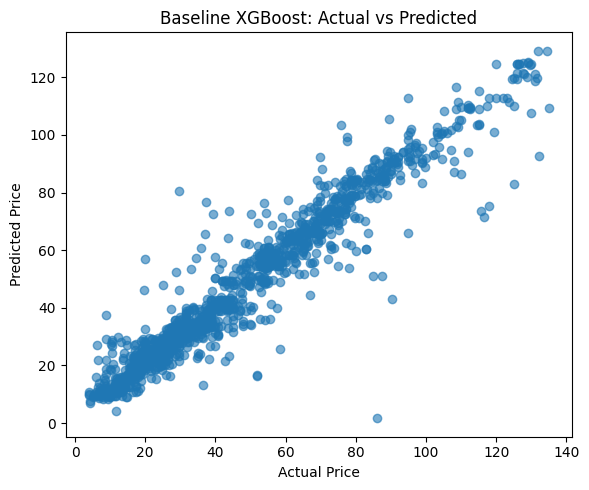

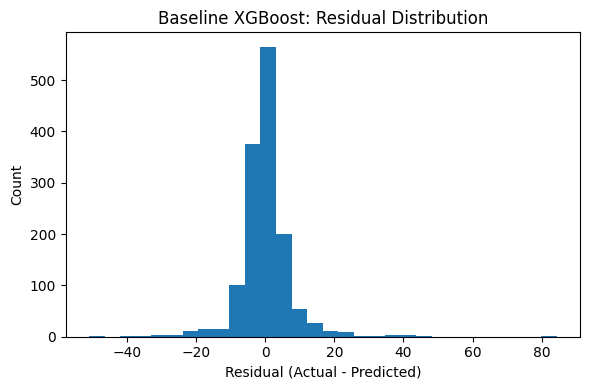

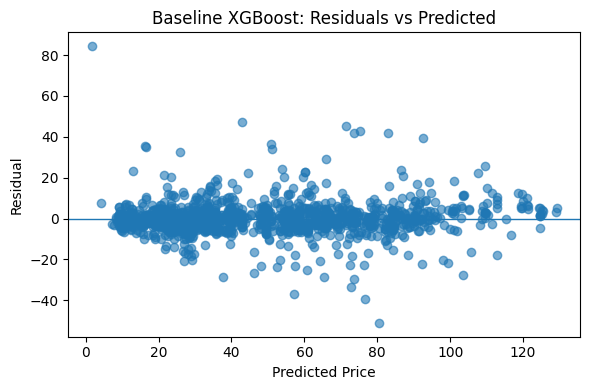

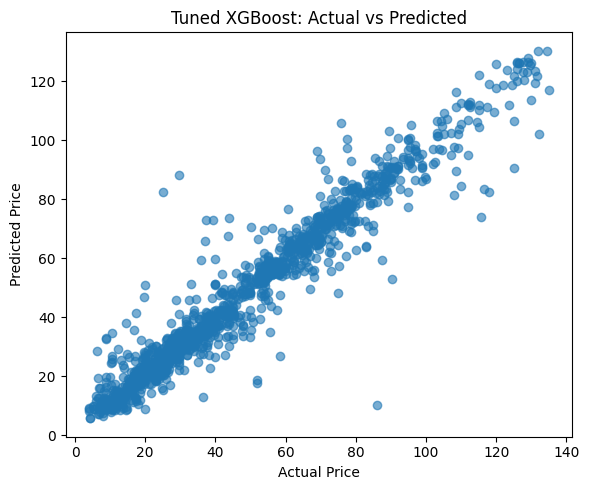

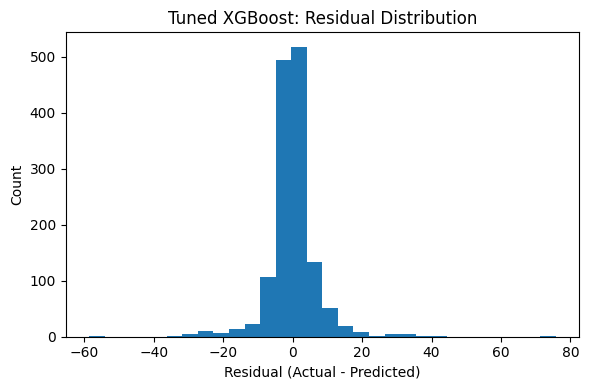

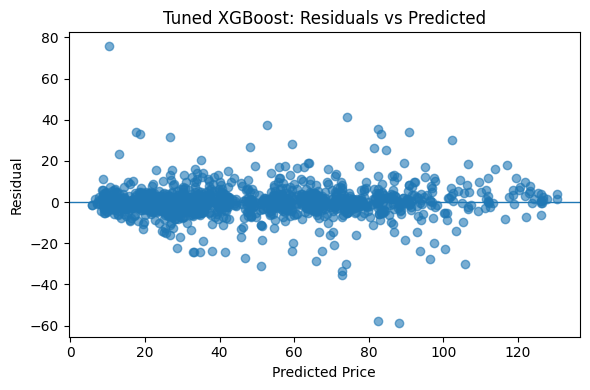

In [43]:
y_pred_base, res_base = regression_plots(baseline_xgb, X_test, y_test, "Baseline XGBoost")
y_pred_tuned, res_tuned = regression_plots(best_xgb, X_test, y_test, "Tuned XGBoost")

SHAP Feature Importance (Global & Local)

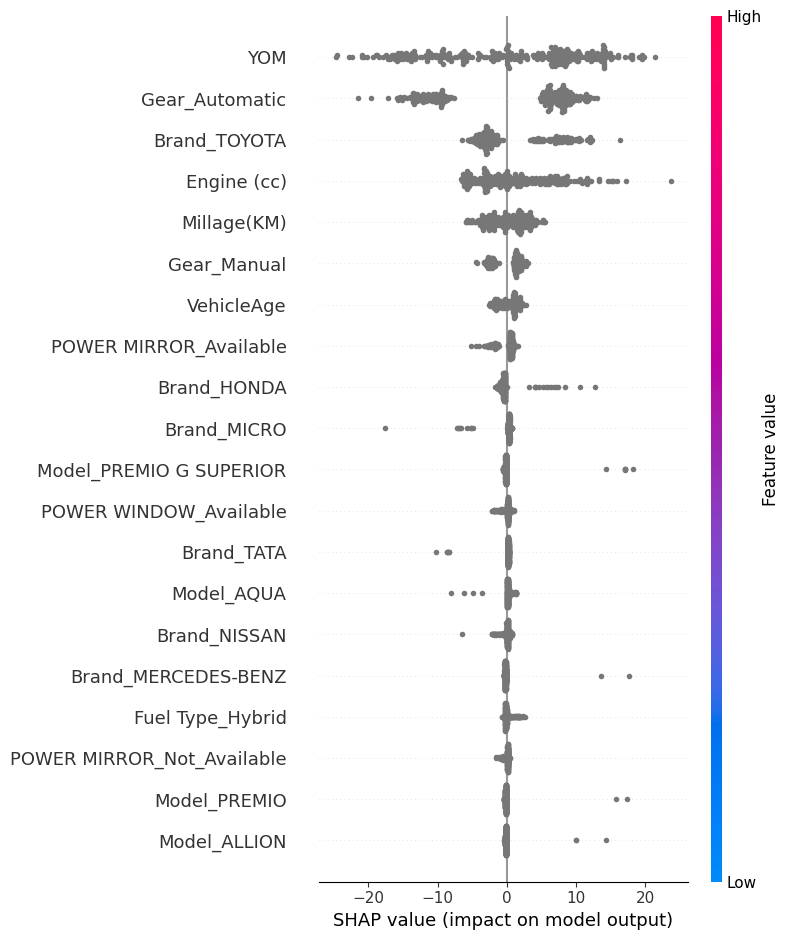

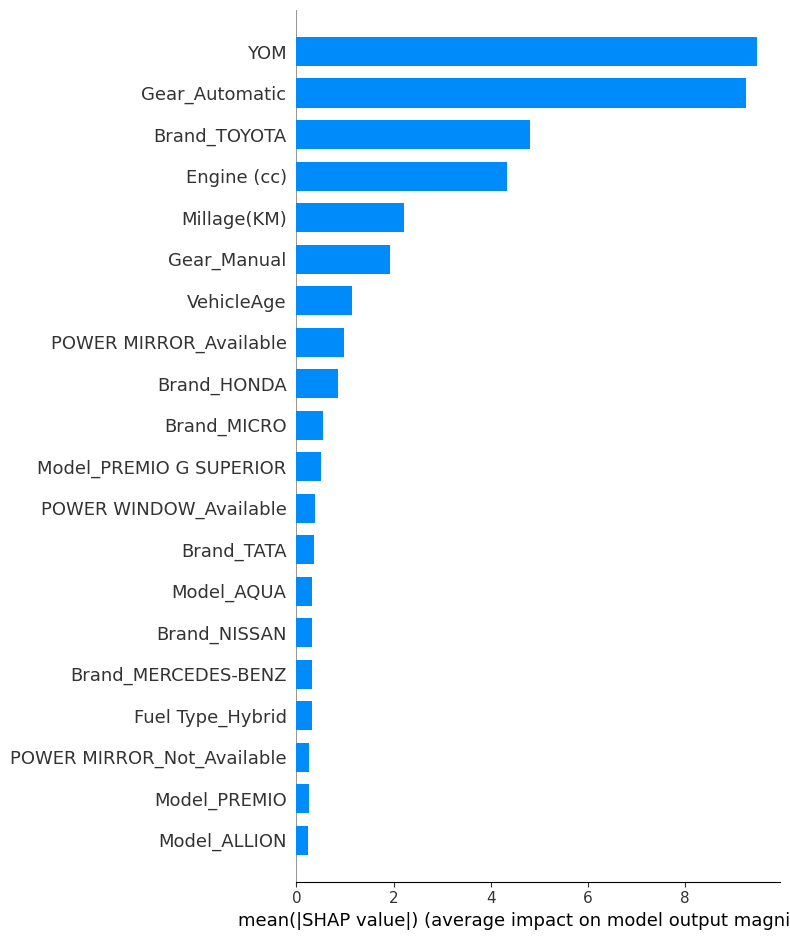

In [44]:
import shap
import numpy as np

preprocessor = best_xgb.named_steps["preprocess"]
xgb_model = best_xgb.named_steps["model"]

X_test_t = preprocessor.transform(X_test)

cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_feature_names])

sample_size = 300
X_sample = X_test_t[:sample_size]

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, feature_names=feature_names)

shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar")



SHAP Waterfall Plot for Single Sample

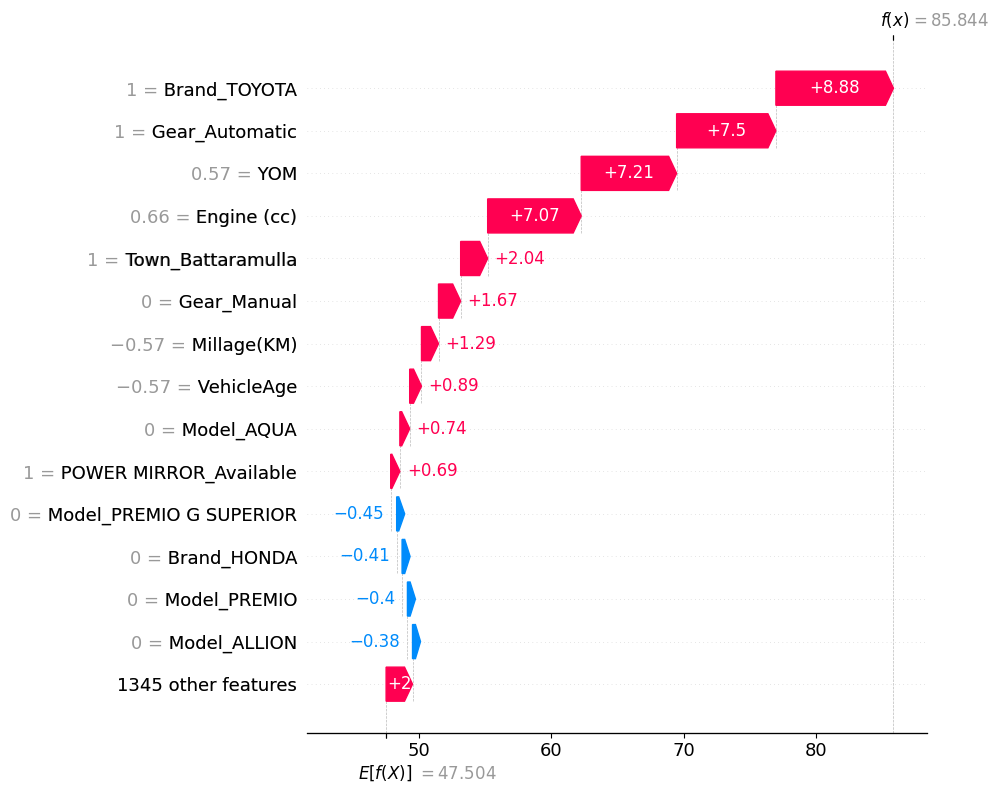

In [45]:
import numpy as np
import shap

idx = 0  

row = X_sample[idx]
if hasattr(row, "toarray"):         
    row_1d = row.toarray().ravel()
else:                                
    row_1d = np.array(row).ravel()

sv_row = shap_values[idx]
sv_row_1d = np.array(sv_row).ravel()

base = explainer.expected_value
base_val = float(np.array(base).ravel()[0])

exp = shap.Explanation(
    values=sv_row_1d,
    base_values=base_val,
    data=row_1d,
    feature_names=feature_names
)

shap.plots.waterfall(exp, max_display=15)

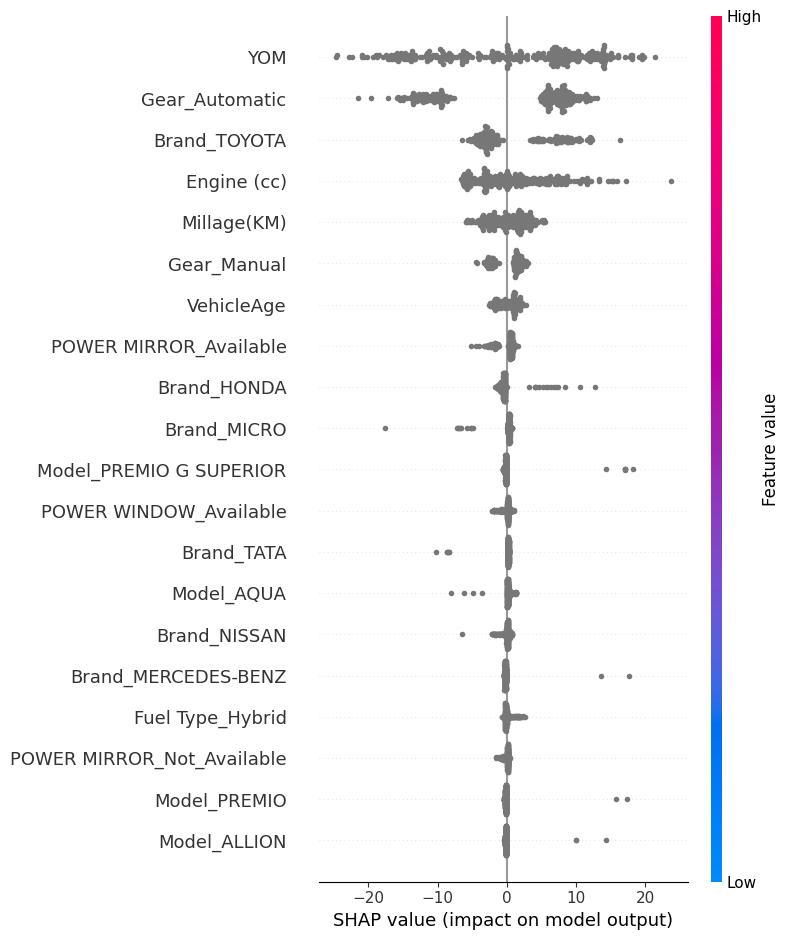

In [46]:
shap.summary_plot(shap_values, X_sample, feature_names=feature_names)
shap.force_plot(explainer.expected_value, shap_values[idx], row_1d, feature_names=feature_names)

Save Final Model & Feature Columns

In [47]:

import pickle

MODEL_PATH = "car_price_model.pkl"
COLS_PATH  = "car_price_columns.pkl"

with open(MODEL_PATH, "wb") as f:
    pickle.dump(best_xgb, f)

feature_cols = [
 'Brand','Model','YOM','Engine (cc)','Gear','Fuel Type','Millage(KM)','Town',
 'Leasing','Condition','AIR CONDITION','POWER STEERING','POWER MIRROR',
 'POWER WINDOW','ListingYear','ListingMonth','VehicleAge'
]

with open(COLS_PATH, "wb") as f:
    pickle.dump(feature_cols, f)

print("Saved:", MODEL_PATH, "and", COLS_PATH)

Saved: car_price_model.pkl and car_price_columns.pkl
